In [15]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import itertools

from torch.utils.data import DataLoader
from torch import nn
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

sys.path.append("..")
from utils import metrics
from utils.data import TimeFusionDataset
from timefusion import TimeFusion
from utils.early_stopper import EarlyStopper

In [16]:
# Import data
train_data = pd.read_csv("../../datasets/exchange/train.csv")
val_data = pd.read_csv("../../datasets/exchange/val.csv")
test_data = pd.read_csv("../../datasets/exchange/test.csv")

# Normalize the signal power of each column
stds = train_data.std()
train_data /= stds
val_data /= stds
test_data /= stds

In [17]:
# Compute device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [18]:
context_length = 60
prediction_length = 30

def get_data_loader(data, context_length):

    dataset = TimeFusionDataset(
        data = data,
        context_length = context_length,
    )

    dataloader = DataLoader(
        dataset = dataset,
        shuffle = True,
        num_workers = 4,
        batch_size = 128,
    )

    return dataloader, dataset

train_loader, train_dataset = get_data_loader(train_data, context_length)
val_loader, val_dataset = get_data_loader(val_data, context_length)
test_loader, test_dataset = get_data_loader(test_data, context_length)

In [19]:
predictor = TimeFusion(
    input_size = train_dataset.data.shape[1],
    output_size = train_data.shape[1],
    rnn_layers = 2,
    rnn_hidden = 10,
    residual_layers = 2,
    residual_hidden = 20,
    scaling = True,
    device = device
)

print("Number of trainable parameters:",sum(p.numel() for p in predictor.parameters()))

Number of trainable parameters: 4318


/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timefusion/examples/../utils/diffusion.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bar_alphas = torch.tensor(


In [20]:
optimizer = torch.optim.Adam(params=predictor.parameters(),lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=120)

predictor.train_network(
    train_loader = train_loader,
    epochs=120,
    val_loader = val_loader,
    val_metrics= {
        "Val MAE": nn.L1Loss(),
    },
    optimizer = optimizer,
    lr_scheduler= lr_scheduler,
    early_stopper=EarlyStopper(patience=20),
    save_weights = True,
    weight_folder = "weights/exchange"
)

Epoch: 1/120: 100%|██████████| 47/47 [00:03<00:00, 11.92batch/s, Training loss=0.8792]


Val MAE: 0.6983 , val_loss: 0.7658 , 


Epoch: 2/120: 100%|██████████| 47/47 [00:03<00:00, 13.36batch/s, Training loss=0.6323]


Val MAE: 0.5597 , val_loss: 0.5242 , 


Epoch: 3/120: 100%|██████████| 47/47 [00:03<00:00, 12.93batch/s, Training loss=0.4180]


Val MAE: 0.4543 , val_loss: 0.3538 , 


Epoch: 4/120: 100%|██████████| 47/47 [00:03<00:00, 13.24batch/s, Training loss=0.2807]


Val MAE: 0.3484 , val_loss: 0.2222 , 


Epoch: 5/120: 100%|██████████| 47/47 [00:03<00:00, 13.35batch/s, Training loss=0.1904]


Val MAE: 0.2806 , val_loss: 0.1510 , 


Epoch: 6/120: 100%|██████████| 47/47 [00:03<00:00, 13.30batch/s, Training loss=0.1482]


Val MAE: 0.2801 , val_loss: 0.1469 , 


Epoch: 7/120: 100%|██████████| 47/47 [00:03<00:00, 13.38batch/s, Training loss=0.1360]


Val MAE: 0.2618 , val_loss: 0.1339 , 


Epoch: 8/120: 100%|██████████| 47/47 [00:03<00:00, 12.96batch/s, Training loss=0.1323]


Val MAE: 0.2515 , val_loss: 0.1227 , 


Epoch: 9/120: 100%|██████████| 47/47 [00:03<00:00, 13.25batch/s, Training loss=0.1359]


Val MAE: 0.2551 , val_loss: 0.1259 , 


Epoch: 10/120: 100%|██████████| 47/47 [00:03<00:00, 13.30batch/s, Training loss=0.1315]


Val MAE: 0.2543 , val_loss: 0.1340 , 


Epoch: 11/120: 100%|██████████| 47/47 [00:03<00:00, 12.57batch/s, Training loss=0.1258]


Val MAE: 0.2429 , val_loss: 0.1177 , 


Epoch: 12/120: 100%|██████████| 47/47 [00:03<00:00, 12.58batch/s, Training loss=0.1218]


Val MAE: 0.2547 , val_loss: 0.1310 , 


Epoch: 13/120: 100%|██████████| 47/47 [00:03<00:00, 12.93batch/s, Training loss=0.1173]


Val MAE: 0.2339 , val_loss: 0.1100 , 


Epoch: 14/120: 100%|██████████| 47/47 [00:03<00:00, 12.88batch/s, Training loss=0.1124]


Val MAE: 0.2339 , val_loss: 0.1114 , 


Epoch: 15/120: 100%|██████████| 47/47 [00:03<00:00, 12.83batch/s, Training loss=0.1136]


Val MAE: 0.2235 , val_loss: 0.1012 , 


Epoch: 16/120: 100%|██████████| 47/47 [00:03<00:00, 12.30batch/s, Training loss=0.1072]


Val MAE: 0.2277 , val_loss: 0.1096 , 


Epoch: 17/120: 100%|██████████| 47/47 [00:03<00:00, 12.95batch/s, Training loss=0.0963]


Val MAE: 0.2152 , val_loss: 0.1007 , 


Epoch: 18/120: 100%|██████████| 47/47 [00:03<00:00, 11.98batch/s, Training loss=0.0979]


Val MAE: 0.2098 , val_loss: 0.0916 , 


Epoch: 19/120: 100%|██████████| 47/47 [00:03<00:00, 13.34batch/s, Training loss=0.0935]


Val MAE: 0.1995 , val_loss: 0.0814 , 


Epoch: 20/120: 100%|██████████| 47/47 [00:03<00:00, 13.12batch/s, Training loss=0.0850]


Val MAE: 0.2022 , val_loss: 0.0913 , 


Epoch: 21/120: 100%|██████████| 47/47 [00:03<00:00, 13.21batch/s, Training loss=0.0817]


Val MAE: 0.1911 , val_loss: 0.0794 , 


Epoch: 22/120: 100%|██████████| 47/47 [00:03<00:00, 12.96batch/s, Training loss=0.0846]


Val MAE: 0.1775 , val_loss: 0.0644 , 


Epoch: 23/120: 100%|██████████| 47/47 [00:03<00:00, 13.31batch/s, Training loss=0.0831]


Val MAE: 0.1882 , val_loss: 0.0778 , 


Epoch: 24/120: 100%|██████████| 47/47 [00:03<00:00, 13.46batch/s, Training loss=0.0783]


Val MAE: 0.1767 , val_loss: 0.0658 , 


Epoch: 25/120: 100%|██████████| 47/47 [00:03<00:00, 13.15batch/s, Training loss=0.0743]


Val MAE: 0.1787 , val_loss: 0.0695 , 


Epoch: 26/120: 100%|██████████| 47/47 [00:03<00:00, 12.31batch/s, Training loss=0.0696]


Val MAE: 0.1835 , val_loss: 0.0815 , 


Epoch: 27/120: 100%|██████████| 47/47 [00:03<00:00, 12.07batch/s, Training loss=0.0722]


Val MAE: 0.1729 , val_loss: 0.0660 , 


Epoch: 28/120: 100%|██████████| 47/47 [00:03<00:00, 12.91batch/s, Training loss=0.0677]


Val MAE: 0.1681 , val_loss: 0.0657 , 


Epoch: 29/120: 100%|██████████| 47/47 [00:03<00:00, 13.44batch/s, Training loss=0.0684]


Val MAE: 0.1626 , val_loss: 0.0584 , 


Epoch: 30/120: 100%|██████████| 47/47 [00:03<00:00, 13.25batch/s, Training loss=0.0682]


Val MAE: 0.1700 , val_loss: 0.0674 , 


Epoch: 31/120: 100%|██████████| 47/47 [00:03<00:00, 13.48batch/s, Training loss=0.0633]


Val MAE: 0.1580 , val_loss: 0.0574 , 


Epoch: 32/120: 100%|██████████| 47/47 [00:03<00:00, 12.92batch/s, Training loss=0.0657]


Val MAE: 0.1629 , val_loss: 0.0629 , 


Epoch: 33/120: 100%|██████████| 47/47 [00:03<00:00, 12.71batch/s, Training loss=0.0632]


Val MAE: 0.1595 , val_loss: 0.0586 , 


Epoch: 34/120: 100%|██████████| 47/47 [00:03<00:00, 13.48batch/s, Training loss=0.0618]


Val MAE: 0.1603 , val_loss: 0.0605 , 


Epoch: 35/120: 100%|██████████| 47/47 [00:03<00:00, 12.92batch/s, Training loss=0.0645]


Val MAE: 0.1622 , val_loss: 0.0617 , 


Epoch: 36/120: 100%|██████████| 47/47 [00:03<00:00, 13.40batch/s, Training loss=0.0655]


Val MAE: 0.1557 , val_loss: 0.0537 , 


Epoch: 37/120: 100%|██████████| 47/47 [00:03<00:00, 13.57batch/s, Training loss=0.0646]


Val MAE: 0.1516 , val_loss: 0.0521 , 


Epoch: 38/120: 100%|██████████| 47/47 [00:03<00:00, 13.35batch/s, Training loss=0.0595]


Val MAE: 0.1524 , val_loss: 0.0521 , 


Epoch: 39/120: 100%|██████████| 47/47 [00:03<00:00, 12.63batch/s, Training loss=0.0605]


Val MAE: 0.1529 , val_loss: 0.0539 , 


Epoch: 40/120: 100%|██████████| 47/47 [00:03<00:00, 12.46batch/s, Training loss=0.0587]


Val MAE: 0.1497 , val_loss: 0.0510 , 


Epoch: 41/120: 100%|██████████| 47/47 [00:03<00:00, 12.62batch/s, Training loss=0.0546]


Val MAE: 0.1562 , val_loss: 0.0583 , 


Epoch: 42/120: 100%|██████████| 47/47 [00:03<00:00, 12.46batch/s, Training loss=0.0578]


Val MAE: 0.1427 , val_loss: 0.0489 , 


Epoch: 43/120: 100%|██████████| 47/47 [00:03<00:00, 13.01batch/s, Training loss=0.0570]


Val MAE: 0.1505 , val_loss: 0.0534 , 


Epoch: 44/120: 100%|██████████| 47/47 [00:03<00:00, 12.67batch/s, Training loss=0.0535]


Val MAE: 0.1380 , val_loss: 0.0422 , 


Epoch: 45/120: 100%|██████████| 47/47 [00:03<00:00, 13.13batch/s, Training loss=0.0541]


Val MAE: 0.1518 , val_loss: 0.0553 , 


Epoch: 46/120: 100%|██████████| 47/47 [00:03<00:00, 13.41batch/s, Training loss=0.0547]


Val MAE: 0.1454 , val_loss: 0.0525 , 


Epoch: 47/120: 100%|██████████| 47/47 [00:03<00:00, 13.36batch/s, Training loss=0.0543]


Val MAE: 0.1461 , val_loss: 0.0500 , 


Epoch: 48/120: 100%|██████████| 47/47 [00:03<00:00, 12.96batch/s, Training loss=0.0536]


Val MAE: 0.1409 , val_loss: 0.0470 , 


Epoch: 49/120: 100%|██████████| 47/47 [00:03<00:00, 12.50batch/s, Training loss=0.0585]


Val MAE: 0.1459 , val_loss: 0.0571 , 


Epoch: 50/120: 100%|██████████| 47/47 [00:03<00:00, 12.65batch/s, Training loss=0.0538]


Val MAE: 0.1409 , val_loss: 0.0483 , 


Epoch: 51/120: 100%|██████████| 47/47 [00:03<00:00, 13.65batch/s, Training loss=0.0541]


Val MAE: 0.1437 , val_loss: 0.0513 , 


Epoch: 52/120: 100%|██████████| 47/47 [00:03<00:00, 12.88batch/s, Training loss=0.0537]


Val MAE: 0.1507 , val_loss: 0.0600 , 


Epoch: 53/120: 100%|██████████| 47/47 [00:03<00:00, 13.02batch/s, Training loss=0.0540]


Val MAE: 0.1364 , val_loss: 0.0429 , 


Epoch: 54/120: 100%|██████████| 47/47 [00:03<00:00, 12.58batch/s, Training loss=0.0503]


Val MAE: 0.1427 , val_loss: 0.0510 , 


Epoch: 55/120: 100%|██████████| 47/47 [00:03<00:00, 12.95batch/s, Training loss=0.0501]


Val MAE: 0.1414 , val_loss: 0.0501 , 


Epoch: 56/120: 100%|██████████| 47/47 [00:03<00:00, 12.69batch/s, Training loss=0.0508]


Val MAE: 0.1411 , val_loss: 0.0534 , 


Epoch: 57/120: 100%|██████████| 47/47 [00:03<00:00, 13.17batch/s, Training loss=0.0531]


Val MAE: 0.1393 , val_loss: 0.0490 , 


Epoch: 58/120: 100%|██████████| 47/47 [00:03<00:00, 13.13batch/s, Training loss=0.0491]


Val MAE: 0.1306 , val_loss: 0.0425 , 


Epoch: 59/120: 100%|██████████| 47/47 [00:03<00:00, 13.60batch/s, Training loss=0.0526]


Val MAE: 0.1332 , val_loss: 0.0434 , 


Epoch: 60/120: 100%|██████████| 47/47 [00:03<00:00, 12.88batch/s, Training loss=0.0503]


Val MAE: 0.1342 , val_loss: 0.0443 , 


Epoch: 61/120: 100%|██████████| 47/47 [00:03<00:00, 12.72batch/s, Training loss=0.0518]


Val MAE: 0.1338 , val_loss: 0.0436 , 


Epoch: 62/120: 100%|██████████| 47/47 [00:03<00:00, 13.06batch/s, Training loss=0.0495]


Val MAE: 0.1302 , val_loss: 0.0397 , 


Epoch: 63/120: 100%|██████████| 47/47 [00:03<00:00, 13.56batch/s, Training loss=0.0478]


Val MAE: 0.1302 , val_loss: 0.0380 , 


Epoch: 64/120: 100%|██████████| 47/47 [00:03<00:00, 13.57batch/s, Training loss=0.0473]


Val MAE: 0.1379 , val_loss: 0.0488 , 


Epoch: 65/120: 100%|██████████| 47/47 [00:03<00:00, 13.39batch/s, Training loss=0.0489]


Val MAE: 0.1261 , val_loss: 0.0403 , 


Epoch: 66/120: 100%|██████████| 47/47 [00:03<00:00, 13.31batch/s, Training loss=0.0457]


Val MAE: 0.1335 , val_loss: 0.0439 , 


Epoch: 67/120: 100%|██████████| 47/47 [00:03<00:00, 13.31batch/s, Training loss=0.0470]


Val MAE: 0.1307 , val_loss: 0.0414 , 


Epoch: 68/120: 100%|██████████| 47/47 [00:03<00:00, 12.96batch/s, Training loss=0.0446]


Val MAE: 0.1250 , val_loss: 0.0347 , 


Epoch: 69/120: 100%|██████████| 47/47 [00:03<00:00, 13.27batch/s, Training loss=0.0435]


Val MAE: 0.1327 , val_loss: 0.0466 , 


Epoch: 70/120: 100%|██████████| 47/47 [00:03<00:00, 13.66batch/s, Training loss=0.0470]


Val MAE: 0.1332 , val_loss: 0.0449 , 


Epoch: 71/120: 100%|██████████| 47/47 [00:03<00:00, 13.64batch/s, Training loss=0.0461]


Val MAE: 0.1322 , val_loss: 0.0454 , 


Epoch: 72/120: 100%|██████████| 47/47 [00:03<00:00, 13.49batch/s, Training loss=0.0459]


Val MAE: 0.1343 , val_loss: 0.0472 , 


Epoch: 73/120: 100%|██████████| 47/47 [00:03<00:00, 13.29batch/s, Training loss=0.0474]


Val MAE: 0.1302 , val_loss: 0.0446 , 


Epoch: 74/120: 100%|██████████| 47/47 [00:03<00:00, 13.81batch/s, Training loss=0.0418]


Val MAE: 0.1291 , val_loss: 0.0385 , 


Epoch: 75/120: 100%|██████████| 47/47 [00:03<00:00, 12.96batch/s, Training loss=0.0449]


Val MAE: 0.1220 , val_loss: 0.0354 , 


Epoch: 76/120: 100%|██████████| 47/47 [00:03<00:00, 13.79batch/s, Training loss=0.0467]


Val MAE: 0.1304 , val_loss: 0.0455 , 


Epoch: 77/120: 100%|██████████| 47/47 [00:03<00:00, 13.63batch/s, Training loss=0.0447]


Val MAE: 0.1248 , val_loss: 0.0365 , 


Epoch: 78/120: 100%|██████████| 47/47 [00:03<00:00, 13.08batch/s, Training loss=0.0430]


Val MAE: 0.1281 , val_loss: 0.0434 , 


Epoch: 79/120: 100%|██████████| 47/47 [00:03<00:00, 12.95batch/s, Training loss=0.0472]


Val MAE: 0.1243 , val_loss: 0.0417 , 


Epoch: 80/120: 100%|██████████| 47/47 [00:03<00:00, 12.65batch/s, Training loss=0.0421]


Val MAE: 0.1252 , val_loss: 0.0385 , 


Epoch: 81/120: 100%|██████████| 47/47 [00:03<00:00, 12.41batch/s, Training loss=0.0470]


Val MAE: 0.1297 , val_loss: 0.0479 , 


Epoch: 82/120: 100%|██████████| 47/47 [00:03<00:00, 12.15batch/s, Training loss=0.0429]


Val MAE: 0.1261 , val_loss: 0.0393 , 


Epoch: 83/120: 100%|██████████| 47/47 [00:03<00:00, 11.96batch/s, Training loss=0.0435]


Val MAE: 0.1389 , val_loss: 0.0584 , 


Epoch: 84/120: 100%|██████████| 47/47 [00:03<00:00, 13.53batch/s, Training loss=0.0451]


Val MAE: 0.1323 , val_loss: 0.0475 , 


Epoch: 85/120: 100%|██████████| 47/47 [00:03<00:00, 12.85batch/s, Training loss=0.0442]


Val MAE: 0.1283 , val_loss: 0.0430 , 


Epoch: 86/120: 100%|██████████| 47/47 [00:03<00:00, 13.21batch/s, Training loss=0.0458]


Val MAE: 0.1308 , val_loss: 0.0486 , 


Epoch: 87/120: 100%|██████████| 47/47 [00:03<00:00, 12.36batch/s, Training loss=0.0448]


Val MAE: 0.1237 , val_loss: 0.0391 , 


Epoch: 88/120: 100%|██████████| 47/47 [00:03<00:00, 13.24batch/s, Training loss=0.0412]


Val MAE: 0.1221 , val_loss: 0.0403 , 


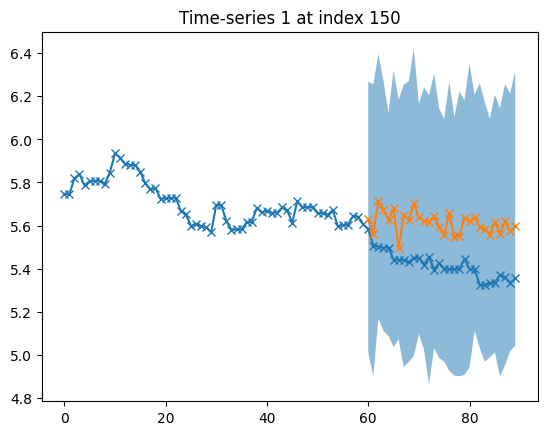

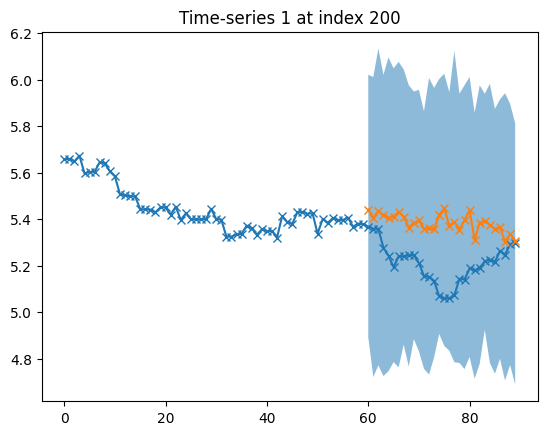

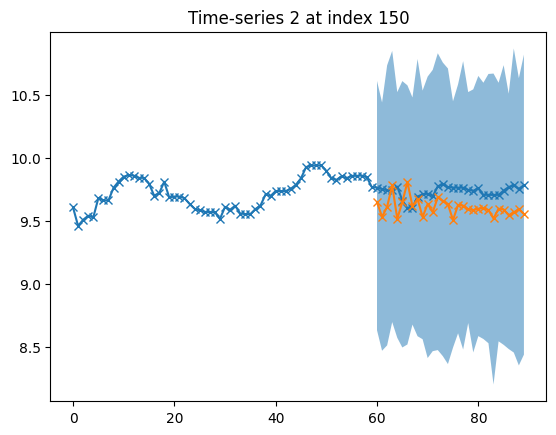

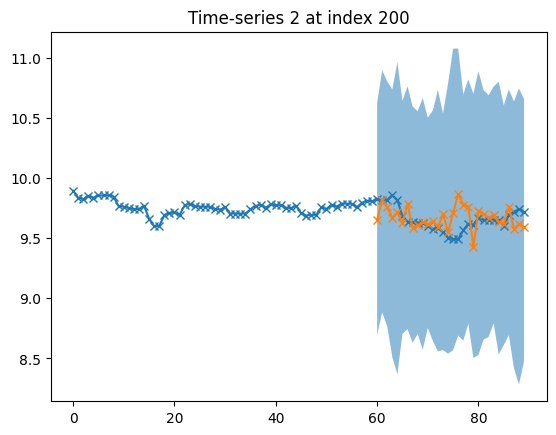

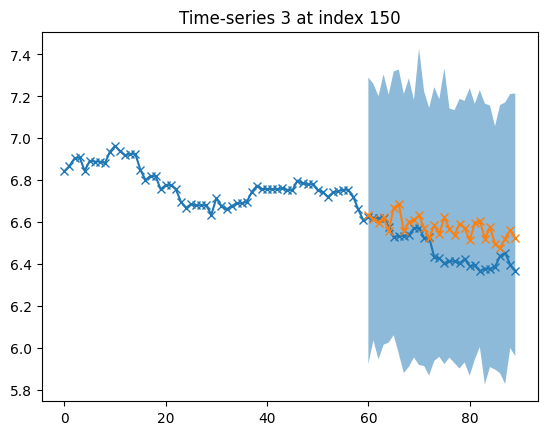

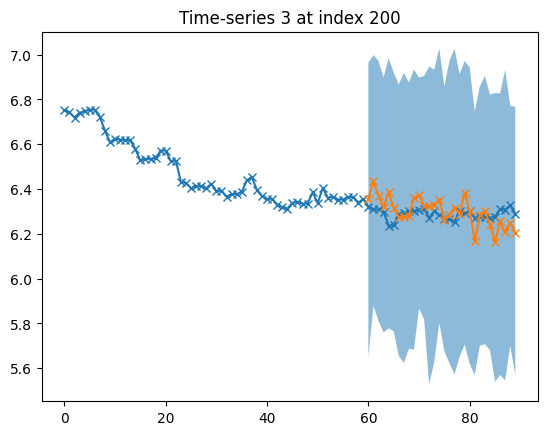

In [21]:
# Sample from model
indices = [150,200]

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
)
samples = samples.cpu()

# Sort samples in ascending order
samples = samples.permute(0,2,3,1).flatten(start_dim=0,end_dim=2).sort()[0].reshape(samples.shape[0],samples.shape[2],samples.shape[3],-1).permute(0,3,1,2)

# Plot some predictions
confidence = 0.9
for ts, i in itertools.product([1,2,3],range(len(indices))):
    plt.figure()
    plt.title(f"Time-series {ts} at index {indices[i]}")
    plt.plot(test_dataset.tensor_data[indices[i]:indices[i]+context_length+prediction_length,ts],"-x")
    plt.plot(list(range(context_length,context_length+prediction_length)),torch.mean(samples[i,:,ts],dim = 0),"-x")
    plt.fill_between(list(range(context_length,context_length+prediction_length)), samples[i,int(confidence*samples.shape[1]),ts], samples[i,int((1-confidence)*samples.shape[1]),ts],alpha=0.5)

In [23]:
# Make samples and extract realisations for last 14 months of test dataset
last_idx = test_dataset.tensor_data.shape[0] - prediction_length - context_length
indices = list(range(last_idx, last_idx - prediction_length*14, -prediction_length))

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
)

realisations = []
for idx in indices:
    realisations.append(
        test_dataset.tensor_data[context_length + idx:context_length + idx + prediction_length].T
    )
realisations = torch.stack(realisations).to(samples.device)


In [24]:
# Calculate metrics
mean_predictions = samples.mean(axis=1)

# MSE, MAE, MDAE
mse = mean_squared_error(realisations.flatten(), mean_predictions.flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())
print("MSE:", mse, "MAE:", mae, "MDAE:", mdae)

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=3) for i in range(realisations.shape[0])])
print("CRPS_sum:", crps_sum, "Variogram_score:", variogram_score)

MSE: 0.042012412 MAE: 0.15260145 MDAE: 0.11435747
CRPS_sum: 0.624789496404784 Variogram_score: 0.04543245967618253
